<a href="https://colab.research.google.com/github/pouyashojaei/datathon-code/blob/Pouya/Forecasting_South_Central.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WiDS hackathon

Jayeon Kim

In [41]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dense, Flatten, LSTM, Conv2D
from tensorflow.keras import Model, Sequential

#file_north = 'north_electricity_weather_history.csv'
file_south_central = 'south_central_electricity_weather_history.csv'

files = [file_south_central]
dfs = [pd.read_csv(file) for file in files]

df_forecast = pd.read_csv('weather_forecasting_San_Antonio.csv')
print(df_forecast.shape)

for df in dfs:
  df.drop_duplicates(subset = "index", keep = 'first', inplace = True) #drop duplicate rows
  #df['Month'] = pd.DatetimeIndex(df['index']).month
  #df['Day'] = pd.DatetimeIndex(df['index']).day
  #df['Hour'] = pd.DatetimeIndex(df['index']).hour
  #df[['Hour', 'Month']] = df[['Hour', 'Month']].astype('category')

df_forecast.head()

(192, 14)


,date_time,tempF,windspeedMiles,precipMM,humidity,visibilityMiles,pressureInches,cloudcover,HeatIndexF,DewPointF,WindChillF,WindGustMiles,FeelsLikeF,uvIndex
0,6/11/21,79,11,0.0,82,6,30,7,83,71,79,16,83,1
1,6/11/21,79,11,0.0,82,6,30,7,83,71,79,16,83,1
2,6/11/21,79,11,0.0,82,6,30,7,83,71,79,16,83,1
3,6/11/21,73,7,0.0,93,2,30,56,78,71,73,11,78,1
4,6/11/21,73,7,0.0,93,2,30,56,78,71,73,11,78,1


## What does the data look like?

### Last four weeks

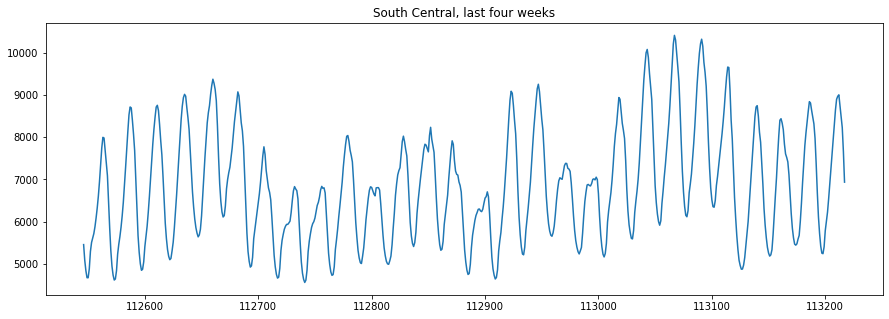

In [42]:
for df in dfs:
  df = df.drop(['index'], axis=1)
  t = 24 * 7 * 4 #24 hours, seven days, four weeks
  plt.figure(figsize=(15,5))
  plt.title(f'{df.columns[0]}, last four weeks')
  plt.plot(df.iloc[-t:,0])
  plt.show()

The pattern of electricity consumption is generally similar for both regions, but the level of electricity consumption is significantly higher in the South Central region.

### For the month of June

In [43]:
'''for df in dfs:
  df = df.drop(['index'], axis=1)

  plt.figure(figsize=(15,5))
  plt.title(f'{df.columns[0]}, June')
  plt.plot(df[df['Month'] == 6].iloc[-500:-200,0])
  plt.show()'''

"for df in dfs:\n  df = df.drop(['index'], axis=1)\n\n  plt.figure(figsize=(15,5))\n  plt.title(f'{df.columns[0]}, June')\n  plt.plot(df[df['Month'] == 6].iloc[-500:-200,0])\n  plt.show()"

## Feature selection
### Part 1: Which features are correlated with which?
Now let us do some feature selection using the correlation matrix.

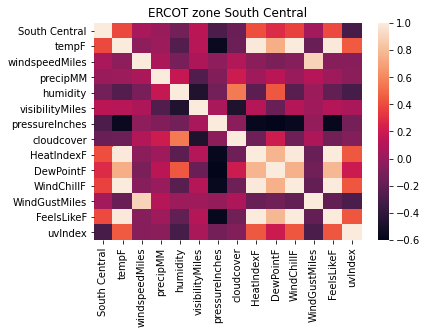

In [44]:
def view_heatmap(df):
  corr = df.corr()
  
  plt.figure()
  plt.title(f'ERCOT zone {df.columns[0]}')
  sns.heatmap(corr)
  plt.show()

for df in dfs:
  df = df.drop(['index'], axis=1)
  view_heatmap(df)


Looking at the heatmaps for three ERCOT zones, we see that the correlation of predictor features and the target feature is not the same for every ERCOT zone. Generally, the correlation between the target feature and predictor features appears weaker in ERCOT zones located in the west. Perhaps this is because western Texas is less susceptible to extreme weather? (compared to coastal Texas that would see a lot of hurricanes). 

Generally, features with stronger correlation appear to be tempF, HeatIndexF, DewPointF, WindChillF and FeelsLikeF, whereas there appears to be a strong negative correlation between electricity demand and uvIndex. This is likely because electricity supply levels sharply decrease during nighttime (when UV levels are lower).

### Part 2: Check for low-variance features
I checked to see whether any low-variance features could be removed from the data.

In [45]:
def view_variance_threshold(df):
  X = pd.DataFrame(df.iloc[:,1:])
  y = pd.DataFrame(df.iloc[0])
  
  sel = VarianceThreshold(threshold=.5)
  sel.fit_transform(X)
  to_remove = X.columns[(np.where(sel.get_support() == False))]
  return list(to_remove)

for df in dfs:
  #df = df.drop(['level_0', 'index'], axis=1)
  print(f'ERCOT weather zone: {df.columns[0]}')
  print(f'Low-variance feature(s): {view_variance_threshold(df)} \n')

ERCOT weather zone: index
Low-variance feature(s): ['pressureInches'] 



For most ERCOT weather zones, pressureInches is a low-variance feature, so the feature will be removed from the data before modelling.

## Modelling

In [46]:
def create_dataset(X, y, time_steps=24):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

def test_time_steps(df, df_forecast, t=24):
  n_rows, n_cols = df.shape
  train = df.iloc[:-168]
  test = df.iloc[-(168+t):] #is the size important?
  forecast = df_forecast[:168+t] #for the first week of June 13-19

  min_max_scaler = MinMaxScaler(feature_range=(0,1))

  train_scaled = min_max_scaler.fit_transform(train)
  train_scaled = pd.DataFrame(train_scaled)
  X_train = pd.DataFrame(train_scaled.iloc[:, 1:])
  y_train = pd.DataFrame(train_scaled.iloc[:, 0])
  
  test_scaled = min_max_scaler.fit_transform(test)
  test_scaled = pd.DataFrame(test_scaled)
  X_test = pd.DataFrame(test_scaled.iloc[:, 1:])
  y_test = pd.DataFrame(test_scaled.iloc[:, 0])

  forecast_scaled = min_max_scaler.fit_transform(forecast)
  forecast_scaled = pd.DataFrame(forecast)
  X_forecast = forecast_scaled #target
  y_forecast = pd.DataFrame(np.zeros(len(X_forecast)))

  X_train_steps, y_train_steps = create_dataset(X_train, y_train, t)
  X_test_steps, y_test_steps = create_dataset(X_test, y_test, t)
  X_forecast_steps, y_forecast_steps = create_dataset(X_forecast, y_forecast, t)

  model = Sequential()
  model.add(LSTM(units=100,
                 activation='relu',
                 return_sequences=True, 
                 input_shape=(X_train_steps.shape[1], 
                              X_train_steps.shape[2])))
  model.add(LSTM(units=100, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', 
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  history = model.fit(
      X_train_steps[-500:,:], 
      y_train_steps[-500:],
      epochs=5,
      batch_size=2,
      validation_split=0.2,
      verbose=1,
      shuffle=False)

  y_pred = model.predict(X_test_steps)
  y_forecast = model.predict(X_forecast_steps)
  n_rows, _, n_features = X_test_steps.shape

  predicted_np = np.column_stack((y_pred, 
                                  np.ones((n_rows, n_features-1)) ))
  predicted_inverse = min_max_scaler.inverse_transform(predicted_np)

  forecast_np = np.column_stack((y_forecast, 
                                 np.ones((n_rows, n_features-1)) ))
  forecast_inverse = min_max_scaler.inverse_transform(forecast_np)

  actual_np = np.column_stack((y_test_steps, 
                               np.ones((n_rows, n_features-1)) ))
  actual_inverse = min_max_scaler.inverse_transform(actual_np)

  return actual_inverse, predicted_inverse, forecast_inverse

In [ ]:
df_sc = dfs[0].drop(['index'], axis=1)
df_forecast = df_forecast.drop(['date_time'], axis=1)

print(f'ERCOT weather region {df_sc.columns[0]}')
to_drop = view_variance_threshold(df_sc)
df_sc = df_sc.drop(to_drop, axis=1)
df_forecast = df_forecast.drop(to_drop, axis=1)

actual_sc, predicted_sc, forecast_sc = test_time_steps(df_sc, df_forecast)

plt.figure(figsize=(15,5))
plt.plot(actual_sc[-168:,0], color='green', label = 'Actual')
plt.plot(predicted_sc[-168:,0], color='red', label = 'Predicted')
#plt.plot(forecast_sc[:168,0], color='blue', label = 'Forecast')
plt.title(f'Predicted electricity consumption for 168 hours')
plt.xlabel('Time')
plt.ylabel('Electricity consumption')
plt.legend()
plt.show()

ERCOT weather region South Central
Epoch 1/5
200/200 [==============================] - 6s 25ms/step - loss: 0.0140 - val_loss: 0.0096
Epoch 2/5
200/200 [==============================] - 5s 23ms/step - loss: 0.0083 - val_loss: 0.0051
Epoch 3/5
200/200 [==============================] - 5s 23ms/step - loss: 0.0093 - val_loss: 0.0061
Epoch 4/5
200/200 [==============================] - 5s 23ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 5/5
200/200 [==============================] - 5s 24ms/step - loss: 0.0038 - val_loss: 0.0054
